<a href="https://colab.research.google.com/github/lucatombesi99/cnn/blob/main/cnn_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/ANN_Challenge2

/content/drive/My Drive/ANN_Challenge2


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import warnings
import logging
import shutil
import glob

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
X_train = np.load('/content/drive/My Drive/ANN_Challenge2/training_dataset_homework2/x_train.npy')
y_train = np.load('/content/drive/My Drive/ANN_Challenge2/training_dataset_homework2/y_train.npy')

In [ ]:
# compute mean and std per feature
data_mean = np.empty(shape=6)
data_std = np.empty(shape=6)
data_max = np.empty(shape=6)
data_min = np.empty(shape=6)
data_median = np.empty(shape=6)

for i in range(6):
  data_mean[i] = X_train[:,:,i].mean()
  data_std[i] = X_train[:,:,i].std()
  data_min[i] = X_train[:,:,i].min()
  data_max[i] = X_train[:,:,i].max()
  data_median[i] = np.median(X_train[:,:,i])

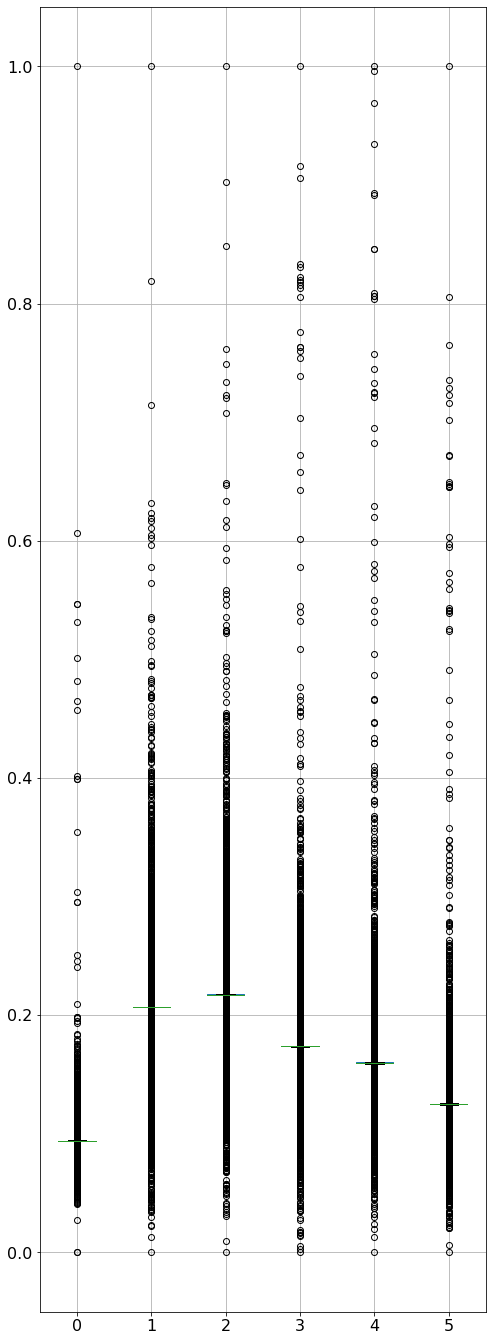

In [ ]:
data_min = np.empty(shape=6)
data_max = np.empty(shape=6)

for i in range(6):
  data_min[i] = X_train[:,:,i].min()
  data_max[i] = X_train[:,:,i].max()

x = np.reshape(X_train,(X_train.shape[0]*X_train.shape[1], 6))
x = (x - data_min)/(data_max-data_min)
x = pd.DataFrame(x)
x.boxplot(figsize=(8,24))

In [ ]:
y = np.argmax(y_train, axis=1)

for i in range(12):
  print(i,"\t",len(y[y ==i]))

AxisError: ignored

In [ ]:
X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [ ]:
class FeatureSelectionLayer(tfkl.Layer):
  def __init__(self, features):
    super(FeatureSelectionLayer, self).__init__()
    self.features = features
  def call(self, inputs):
    return tf.gather(inputs, indices=self.features, axis = 2)





In [ ]:
input_shape = X_train.shape[1:]
input_shape

(36, 6)

In [ ]:
def build_model(input_shape, classes, mean, std, features):
    input_layer = tfkl.Input(input_shape)

    scaler = CustomScalerLayer(mean,std)(input_layer)

    feature_selector = FeatureSelectionLayer(features)(scaler)

    # BLOCK 1
    conv1 = tfkl.Conv1D(64, 8, padding='same')(feature_selector)
    conv1 = tfkl.Activation('relu')(conv1)

    conv2 = tfkl.Conv1D(64, 5, padding='same')(conv1)
    conv2 = tfkl.Activation('relu')(conv2)

    conv3 = tfkl.Conv1D(64, 3, padding='same')(conv2)

    # expand channels for the sum

    shortcut = tfkl.Conv1D(filters=64, kernel_size=1, padding='same')(feature_selector)
    shortcut = tfkl.BatchNormalization()(shortcut)

    output_layer_block_1 = tfkl.add([shortcut, conv3])
    output_layer_block_1 = tfkl.Activation('relu')(output_layer_block_1)

    # BLOCK 2
    conv1 = tfkl.Conv1D(128, 8, padding='same')(output_layer_block_1)
    conv1 = tfkl.Activation('relu')(conv1)

    conv2 = tfkl.Conv1D(128, 5, padding='same')(conv1)
    conv2 = tfkl.Activation('relu')(conv2)

    conv3 = tfkl.Conv1D(128, 3, padding='same')(conv2)

    # expand channels for the sum

    shortcut = tfkl.Conv1D(filters=128, kernel_size=1, padding='same')(output_layer_block_1)
    shortcut = tfkl.BatchNormalization()(shortcut)

    output_layer_block_2 = tfkl.add([shortcut, conv3])
    output_layer_block_2 = tfkl.Activation('relu')(output_layer_block_2)

    # BLOCK 3
    #conv1 = tfkl.Conv1D(128, 8, padding='same')(output_layer_block_2)
    #conv1 = tfkl.Activation('relu')(conv1)

    #conv2 = tfkl.Conv1D(128, 5, padding='same')(conv1)
    #conv2 = tfkl.Activation('relu')(conv2)

    #conv3 = tfkl.Conv1D(128, 3, padding='same')(conv2)

    # no need to expand channels because they are equal
    #shortcut = tfkl.BatchNormalization()(output_layer_block_2)

    #output_layer_block_3 = tfkl.add([shortcut, conv3])
    #output_layer_block_3 = tfkl.Activation('relu')(output_layer_block_3)

    # FINAL
    #attention = tfkl.MultiHeadAttention(10,32)(output_layer_block_3, output_layer_block_3)

    #gap_layer = tfkl.GlobalAveragePooling1D()(output_layer_block_3)

    lstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(output_layer_block_2)
    lstm = tfkl.Dropout(0.5)(lstm)
    lstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(lstm)
    lstm = tfkl.Dropout(0.5)(lstm)

    attention = tfkl.MultiHeadAttention(10,32)(lstm, lstm)

    gap_layer = tfkl.GlobalAveragePooling1D()(attention)
    classifier = tfkl.Dense(128)(gap_layer)
    classifier = tfkl.Dropout(0.5)(classifier)

    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    return model

In [ ]:
classes = 12
batch_size = 64
epochs = 200

In [ ]:
class CustomScalerLayer(tfkl.Layer):
  def __init__(self, mean, std):
    super(CustomScalerLayer, self).__init__()
    self.mean = mean
    self.std = std
  def call(self, inputs):
    return (inputs - self.mean)/self.std

In [ ]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
X_train.shape, y_train.shape

((2429, 36, 6), (2429, 12))

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [ ]:
X_valid= X_train[2000:,:,:]
Y_valid= y_train[2000:,:]
X_train=X_train[:2000,:,:]
y_train=y_train[:2000,:]

In [ ]:
# compute mean and std per feature
data_mean = np.empty(shape=6)
data_std = np.empty(shape=6)
data_max = np.empty(shape=6)
data_min = np.empty(shape=6)
data_median = np.empty(shape=6)
data_iqr = np.empty(shape=6)

for i in range(6):
  data_mean[i] = X_train[:,:,i].mean()
  data_std[i] = X_train[:,:,i].std()
  data_min[i] = X_train[:,:,i].min()
  data_max[i] = X_train[:,:,i].max()
  data_median[i] = np.median(X_train[:,:,i])
  data_iqr[i] = np.subtract(*np.percentile(X_train[:,:,i], [75, 25]))

In [ ]:
model = build_model(input_shape, classes, data_mean, (data_max-data_min),[0,1,2,3,4,5])
history = model.fit(
      x = X_train,
      y = y_train,
      batch_size = batch_size,
      epochs = epochs,
      validation_split=.2,
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5),

      ]
).history


Epoch 1/200
31/31 [==============================] - 18s 89ms/step - loss: 2.0627 - accuracy: 0.3392 - val_loss: 2.2068 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 1s 21ms/step - loss: 1.8797 - accuracy: 0.3824 - val_loss: 2.1399 - val_accuracy: 0.3477 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 1s 21ms/step - loss: 1.7786 - accuracy: 0.4189 - val_loss: 2.1847 - val_accuracy: 0.3498 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 1s 20ms/step - loss: 1.7277 - accuracy: 0.4061 - val_loss: 2.0695 - val_accuracy: 0.3519 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 1s 22ms/step - loss: 1.6200 - accuracy: 0.4653 - val_loss: 2.1056 - val_accuracy: 0.3498 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 1s 21ms/step - loss: 1.5455 - accuracy: 0.4817 - val_loss: 2.1324 - val_accuracy: 0.3498 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 1s 21ms/step - l

In [ ]:

from itertools import combinations
array=[0,1,2,3,4,5]
list_combinations = list(combinations(array, 5))
results = {}

for i in range(len(list_combinations)):

  filename='log'+str(i)+'.csv'
  history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)
  model = build_model(input_shape, classes, data_mean, (data_max-data_min),list_combinations[i])
  history = model.fit(
      x = X_train,
      y = y_train,
      batch_size = batch_size,
      epochs = epochs,
      validation_split=.2,
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5),
          history_logger
      ]
  ).history
  max = np.argmax(history['val_accuracy'])
  results[str(i)] = {'train_accuracy': history['accuracy'][max],'val_accuracy': history['val_accuracy'][max]}




Epoch 1/200
31/31 [==============================] - 2s 27ms/step - loss: 2.0646 - accuracy: 0.3572 - val_loss: 2.2407 - val_accuracy: 0.3765 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 1.7855 - accuracy: 0.4195 - val_loss: 1.9609 - val_accuracy: 0.4074 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 1.6413 - accuracy: 0.4611 - val_loss: 1.9683 - val_accuracy: 0.4321 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 0s 12ms/step - loss: 1.4663 - accuracy: 0.5064 - val_loss: 1.8019 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 0s 14ms/step - loss: 1.3565 - accuracy: 0.5311 - val_loss: 1.7506 - val_accuracy: 0.4383 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 0s 13ms/step - loss: 1.3270 - accuracy: 0.5409 - val_loss: 1.7127 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 0s 14ms/step - lo